# Sedaro Rendezvous Tutorial Notebook 
Demonstrates using the Sedaro API to calculate *Hohmann Rendezvous* maneuvers between two satellites via a Jupyter notebook. After performing the transfer manuevers, a fine tuning algorithm will take over and bring the chaser close to the target. Note: This notebook uses pre-defined Scenario and Agent branches to reduce the size of this notebook. 

After a brief setup section, this notebook walks you thru the steps of calculating and setting up three manuevers modes for a chaser spacecraft in a circular orbit to rendezvous with another Target spacecraft in a coplanar circular orbit.

1. First Manuever(DV1): Start a Hohmann transfer to raise the orbit of the chaser satellite to the same altitude as the target satellite.
2. Second Manuever(DV2): Complete the Hohmann transfer to match the velocity of the target satellite.
3. Engage the **VariableThrustRelativeManeuverAlgorithm**: Brings the chaser spacecraft closer to the target spacecraft via a series of small speed up/slow down thruster burns.

Note: The chaser satellite is configured with 6 thrusters, one on each body frame direction(+/- X,Y,Z). The spacecraft attitude will stay oriented so +Y is toward the orbits velocity vector(Ram) and -Z is pointing toward Nadir. 

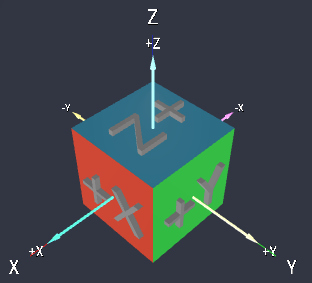

## Important: Read Before Running

This notebook makes changes to agent and scenario branches indicated in the settings section. Ensure any changes to the target branches are saved prior to running this code. Sedaro recommends committing current changes and creating new branches in the target repositories to avoid loss of work.

This notebook also requires that you have previously generated an API key in the web UI. That key should be stored in a file called `secrets.json` in the same directory as this notebook with the following format:

```json
{
    "API_KEY": "<API_KEY>"
}
```

API keys grant full access to your repositories and should never be shared. If you think your API key has been compromised, you can revoke it in the user settings interface on the Sedaro website.

## Sedaro python client setup
Note: More information about the sedaro-python client can be found here: [https://github.com/sedaro/sedaro-python]


In [2]:
import sedaro
import math
import numpy as np
import json
import matplotlib.pyplot as plt
import hohmann_utils as hohmann

In [6]:
Sedaro_api_host  = "https://api.sedaro.com" 

# Set your API token value either directly or via loading a secrets file
# !! NOTE !!  Be careful not to check in your API Key into a source control repo  !! Note !!
secretPath = '../secrets.json' 
with open(secretPath, 'r') as file:
    Sedaro_api_token = json.load(file)['API_key']
    
sedaroAPI = sedaro.SedaroApiClient(api_key=Sedaro_api_token, host=Sedaro_api_host)

Learning Resources for Hohmann Transfers:
- Fundamentals of Astrodynamics 1971 (Bate, Mueller, White) pg 163, 362
- Fundamentals of Astrodynamics and Applications Fifth Edition 2022 (Vallado) pg 329, 367
 

In [7]:
# helper constants and functions
from hohmann_utils import Earth_radius_km, earth_u_ER, sec_per_TU, angle_between, unit_vector, g
km_per_ER = Earth_radius_km

# Overview

```mermaid
flowchart TD
  node_1("Orbits")
  node_2("Agents")
  node_3("Hohmann Calculations")
  node_4["Delta V Maneuvers"]
  subgraph DV1
      node_6("Calc first Delta V")
      node_7("Calc Fuel burn")
      node_8("Delta Mass from burn 1")
  end
  node_6 --> node_4
  node_9("Calc Delta 2")
  node_5["Simulation"]
  node_1 --> node_3
  node_1 --> node_2
  node_3 --> node_6
  node_6 --> node_7
  node_7 --> node_8
  node_8 --> node_9
  node_9 --> node_4
  node_4 --> node_2
  node_2 --> node_5
```

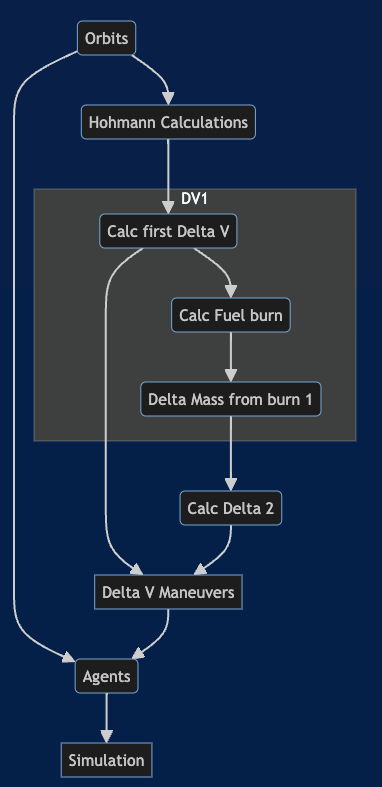

Use a pre-defined Scenario with two space agents in co-planar circular orbits, a target agent and a chaser.  

In [8]:
scenario_branch_id = "PMBkySDKhX5KjQj9BnjxnV" 
chaser_agent_branch_id = "PMBkyRgDzk3nQR5LZxy9ws" 
target_agent_branch_id = "PMBkyRnxczq7CtdXRt8yR4"

scenario_branch     = sedaroAPI.scenario(scenario_branch_id)
chaser_agent_branch = sedaroAPI.agent_template(chaser_agent_branch_id)
target_agent_branch = sedaroAPI.agent_template(target_agent_branch_id)


# Load the agents 
First lets load the two space agents in order to calculate thier orbit radius and the phase angle between them

In [9]:
chaser_agent_name = "Chaser"
target_agent_name = "Target"

chaser_agent = scenario_branch.Agent.get_where(name=chaser_agent_name)[0]
target_agent = scenario_branch.Agent.get_where(name=target_agent_name)[0]


Note: The eci initial positions for the spacecraft is already calculated  

In [10]:
# get the initial positions of the agents
chaser_initial_position = chaser_agent.position
target_initial_position = target_agent.position

# calculate the agents orbit radius
chaser_radius_km =  np.linalg.norm( chaser_initial_position['eci'] )
target_radius_km =  np.linalg.norm( target_initial_position['eci'] )

phase_angle_deg =  angle_between(chaser_initial_position['eci'], target_initial_position['eci']) * 180 / math.pi

Calc the two hohmann manuever times and delta V

In [11]:
# convert the radii to canonical units
a_chaser_ER = hohmann.calc_radii_canonical_units(chaser_radius_km)
a_target_ER = hohmann.calc_radii_canonical_units(target_radius_km) 
a_chaser_ER, a_target_ER

(1.0974992804716326, 1.567856114959475)

Calculate the wait time till the first transfer orbit burn. Aka, how long until the two satellites are in the correct relative starting positions to rendezvous with each other at the end of the Hohmann transfer burns.

In [12]:
wait_seconds_to_dv1 = hohmann.calc_hohmann_transfer_wait_time(a_chaser_ER, a_target_ER, phase_angle_deg, k=0)*sec_per_TU
wait_seconds_to_dv1

12545.433914106945

and how long until dv2

In [13]:
transfer_orbit_time_dv1_to_dv2_secs =hohmann.calc_hohmann_transfer_time(a_chaser_ER, a_target_ER)*sec_per_TU
transfer_orbit_time_dv1_to_dv2_secs

3899.504072553566

and the actual delta V burn amounts

In [14]:
dv_start, dv_end = hohmann.calc_hohmann_transfer_dvs(a_chaser_ER, a_target_ER)
total_delta_v_ERperTU = dv_start + dv_end 
dv_start *= km_per_ER/sec_per_TU
dv_end *= km_per_ER/sec_per_TU
total_delta = dv_start + dv_end

# in km/s
dv_start, dv_end, total_delta

(0.6387906775042252, 0.5840903571011151, 1.2228810346053405)

Convert the Hosmann DV's into thruster burn time required

We approximate:

m * Delta-v = F*t

F = m * Delta-v / t

t = m * Delta-v / F

First lets get the mass of the chaser 

In [34]:
chaser_drymass = chaser_agent_branch.mass
chaser_fuel_reservoir = chaser_agent_branch.FuelReservoir.get_first()
fuel_mass = sum( [tank.wetMass for tank in chaser_fuel_reservoir.fuelTanks] ) 
chaser_filled_fuel_mass  = fuel_mass + chaser_drymass

then obtain the thruster ISP and calculate the burn fuel rate (kg per sec)

In [35]:
thruster_ISP = chaser_agent_branch.Thruster.get_first().isp
burn_fuel_rate_kg_per_sec = chaser_filled_fuel_mass/(g*thruster_ISP)

With the fuel rate, calculate the dv 1 and 2 burn lengths and fuel used

In [36]:
dv_1_m_per_sec = dv_start * 1000
dv_2_m_per_sec = dv_end * 1000

dv_1_burn_length_secs = dv_1_fuel_mass * dv_1_m_per_sec / thruster_ISP
fuel_used_dv1         = dv_1_burn_length_secs * burn_fuel_rate_kg_per_sec

dv_1_fuel_mass = chaser_filled_fuel_mass # kg
dv_2_fuel_mass = dv_1_fuel_mass -  fuel_used_dv1 # kg

dv_2_burn_length_secs = dv_2_fuel_mass * dv_2_m_per_sec / thruster_ISP
fuel_used_dv2 = dv_2_burn_length_secs * burn_fuel_rate_kg_per_sec

In [40]:
dv_1_burn_length_secs, dv_2_burn_length_secs

(56.78139355593114, 51.78553549817648)

Chaser agent -Y thruster is already aligned with the negative Velocity vector (-**Anti-Ram**).

The Relative Schedule for the Chaser agent is already setup as well.

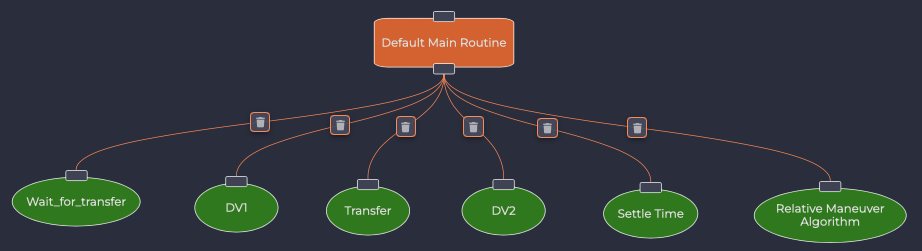

We will set the Delta V N values for DV1 and DV2 so lets find the blocks we need to adjust:

In [37]:
dv1_block = chaser_agent_branch.StaticThrustControlAlgorithm.get_where(name='Maneuver Thrust DV1')[0]
thruster = next(iter(dv1_block.thrusters.keys()))
dv1_block.update( thrusters= {thruster.id: {'thrust': thruster_ISP} })

dv2_block = chaser_agent_branch.StaticThrustControlAlgorithm.get_where(name='Maneuver Thrust DV2')[0]
thruster = next(iter(dv2_block.thrusters.keys()))
dv2_block.update( thrusters= {thruster.id: {'thrust': thruster_ISP} })


StaticThrustControlAlgorithm(
   disabled=False
   id='PLxhH3m4GGcj6ThkMMfnB6'
   name='Maneuver Thrust DV2'
   rate=None
   thrustCommands=None
   thrusterGroups={}
   thrusters={'PLxh55BnBYqvRxlSzQ8RP9': {'thrust': 2250.0}}
   timeStepDriver=None
   type='StaticThrustControlAlgorithm'
)

Next we update the burn schedules for each phase

In [38]:
relative_schedule = chaser_agent_branch.RelativeSchedule.get_where(name = 'Default Main Routine')[0]
# update the existing schedule, which expects minutes
for routine, data in relative_schedule.scheduleData.items():
    match  routine.name: 
        case 'Wait_for_transfer':
            data['activeTimes'][0][0]['min'] = 0
            data['activeTimes'][0][1]['min']  = (wait_seconds_to_dv1 - dv_1_burn_length_secs )/60.0 
        case 'DV1':
            data['activeTimes'][0][0]['min'] = (wait_seconds_to_dv1 - dv_1_burn_length_secs )/60.0 
            data['activeTimes'][0][1]['min']  = (wait_seconds_to_dv1 )/60.0 
        case 'Transfer':
            data['activeTimes'][0][0]['min'] = (wait_seconds_to_dv1 )/60.0 
            data['activeTimes'][0][1]['min']  = (wait_seconds_to_dv1 + transfer_orbit_time_dv1_to_dv2_secs - dv_2_burn_length_secs )/60.0
        case 'DV2':
            data['activeTimes'][0][0]['min'] = (wait_seconds_to_dv1 + transfer_orbit_time_dv1_to_dv2_secs - dv_2_burn_length_secs )/60.0
            data['activeTimes'][0][1]['min']  = (wait_seconds_to_dv1 + transfer_orbit_time_dv1_to_dv2_secs )/60.0
        case 'Settle Time':
            data['activeTimes'][0][0]['min'] = (wait_seconds_to_dv1 + transfer_orbit_time_dv1_to_dv2_secs )/60.0
            data['activeTimes'][0][1]['min']  = (wait_seconds_to_dv1 + transfer_orbit_time_dv1_to_dv2_secs + 60 )/60.0
        case 'Relative Maneuver Algorithm':
            data['activeTimes'][0][0]['min'] = (wait_seconds_to_dv1 + transfer_orbit_time_dv1_to_dv2_secs + 60 )/60.0
            data['activeTimes'][0][1]['min']  = 1440.0 # minutes in a day
        case _:
            print(f'Unknown routine id {routine.id}')

relative_schedule.update(scheduleData=relative_schedule.data['scheduleData'])


RelativeSchedule(
   activeSubroutine=None
   defaultSubroutine='PLxkBYb5cdCpR2Cjhx6Mpm'
   disabled=False
   id='PLxBzFxMZ3FKVvCBtTH6C5'
   isActive=False
   mainRoutine='PLxBzFxMZ3FKVvCBtTH6C5'
   name='Default Main Routine'
   parentRoutines=[]
   pathToActiveLeaf=[]
   scheduleData={'PLxC4Nqcg55vqBRhwSVpv9': {'activeTimes': [[{'min': 208.14420867585022}, {'min': 209.09056523511575}]]}, 'PLxC4NqfgNBRJv7hGPSFxW': {'activeTimes': [[{'min': 273.2192075193723}, {'min': 274.0822997776752}]]}, 'PLxC4NqhfyGTjLH59tLtrN': {'activeTimes': [[{'min': 275.0822997776752}, {'min': 1440.0}]]}, 'PLxhrYrJJWTPFNBnmbBCCt': {'activeTimes': [[{'min': 209.09056523511575}, {'min': 273.2192075193723}]]}, 'PLxkBYb5cdCpR2Cjhx6Mpm': {'activeTimes': [[{'min': 0.0}, {'min': 208.14420867585022}]]}, 'PMCBmqNmzSDlvZS8Zwrg7D': {'activeTimes': [[{'min': 274.0822997776752}, {'min': 275.0822997776752}]]}}
   startElapsedTime={'s': 0.0}
   subroutines=['PLxC4NqfgNBRJv7hGPSFxW', 'PLxC4Nqcg55vqBRhwSVpv9', 'PMCBmqNmzSDlvZ

Run the Sim

In [39]:
sim = scenario_branch.simulation
# Start scenario
sim.start()
# Wait for it to finish, then download the results
results = sim.results_poll()

Downloading...: 100%|██████████[00:09<00:00]


First we summarize the Chaser agent results so we can find the block IDs we will need to determine how close the chaser get to the target satellite agent.

In [41]:

results.agent("Chaser").summarize()

---------------------------------------------------------------------------
                            Agent Result Summary                           
                                  'Chaser'                                 
---------------------------------------------------------------------------
🧩 Simulated Modules
    • Guidance, Navigation, & Control
    • Command & Data Handling

📦 Available Blocks
    ----------------------------------------------------------
    |                  id                         name       |
    ----------------------------------------------------------
    | root                       |                           |
    | YddJw9jfT-IveoP86XQjA      | <Unnamed Block>           |
    | PMBf5gNv6tJzYpysn9KzkW     | Thruster -Z               |
    | PMBf55TdTRq9M3gPTGrxzh     | Thruster +Z               |
    | PMBf4K79xkN74mwKDqJqKX     | Thruster -X               |
    | PMBf3HQC743T8LswVppn59     | Thruster +X               |
    | PMBf26LRpyNgmhV

Analyze the results by plotting the change of some orbit elements over time 


Note: the <Unnamed Block> id of YddJw9jfT-IveoP86XQjA is the block holding the orbital elements and use the legend call of matplotlib.pyplot to ensure the labels don't overlap the data plot


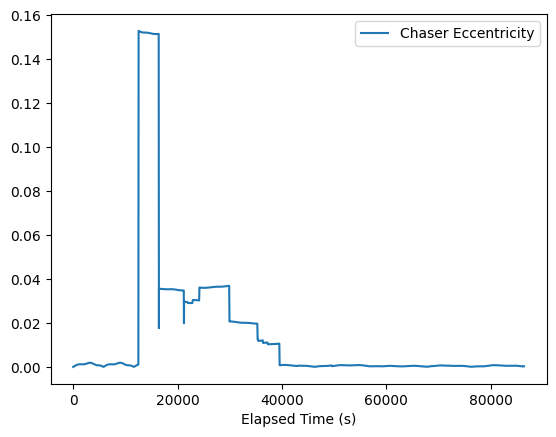

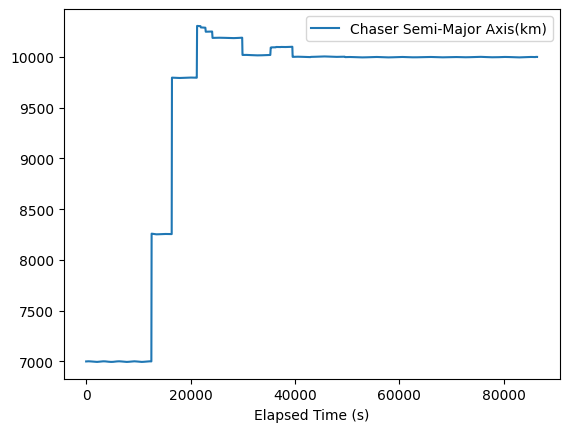

In [42]:
import matplotlib.pyplot as plt
results.agent('Chaser').block('YddJw9jfT-IveoP86XQjA').orbitalElements.e.plot(label='Chaser Eccentricity', show=False)
plt.legend()
plt.show()
results.agent('Chaser').block('YddJw9jfT-IveoP86XQjA').orbitalElements.a.plot(label='Chaser Semi-Major Axis(km)', show=False)
plt.legend()
plt.show()


Plot the -Y Thruster on/off times and the change in the chasers fuel wet mass over time. 

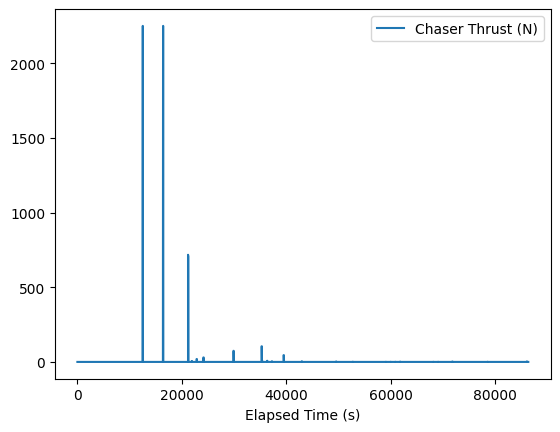

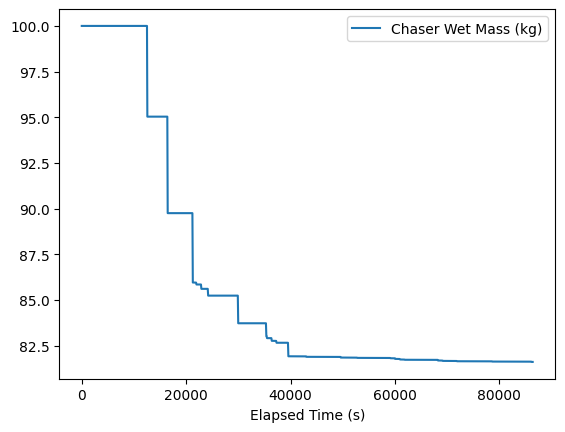

In [43]:
results.agent('Chaser').block('PLxh55BnBYqvRxlSzQ8RP9').thrust.plot(label='Chaser Thrust (N)', show=False)
plt.legend()
plt.show()
results.agent('Chaser').block('PLxhCcSfP9VJ9hd3p3vmPc').wetMass.plot(label='Chaser Wet Mass (kg)', show=False)
plt.legend()
plt.show()

Close up of a Variable Thrust Relative Maneuver Algorithm Burn from the Sedaro Web interface
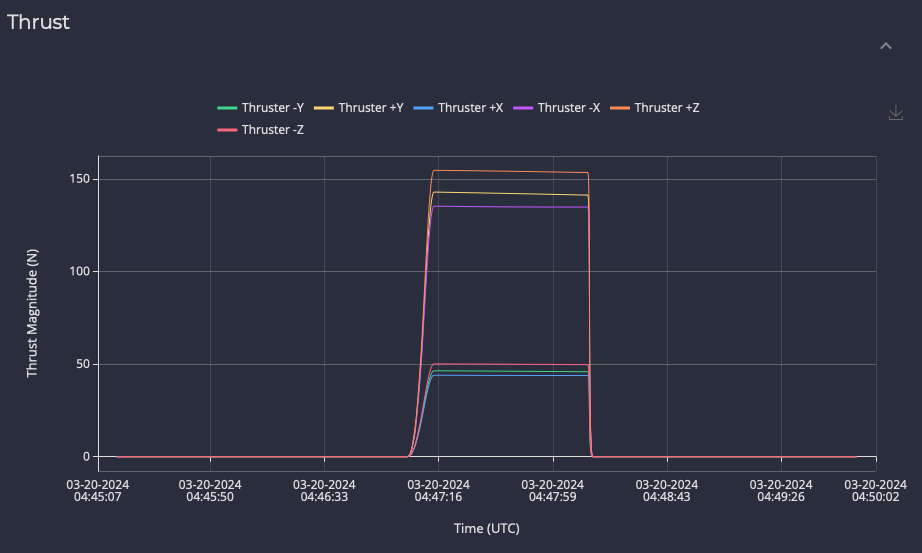

Maneuver plot via the Sedaro-web client, camera situated to be perpendicular to the two co-planer orbits

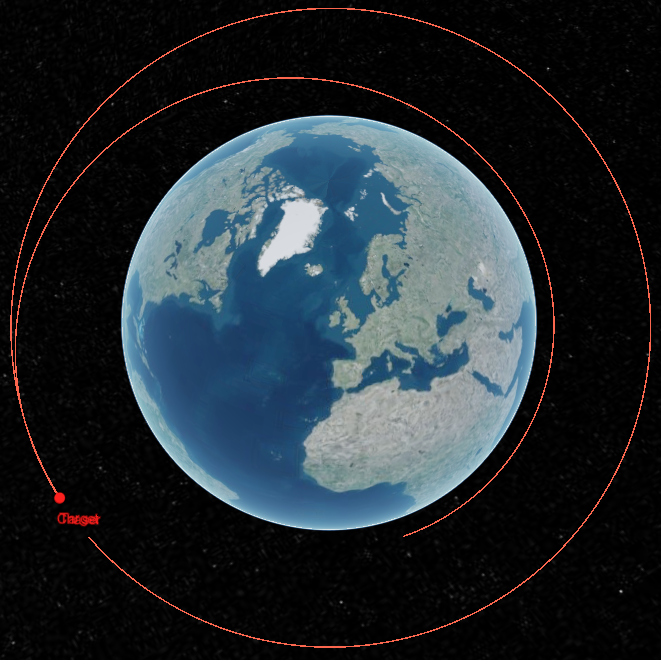

End of Hohmann Transfer - Delta due to simplification of Delta Mass during the Burn phases and other ideal condition assumptions 

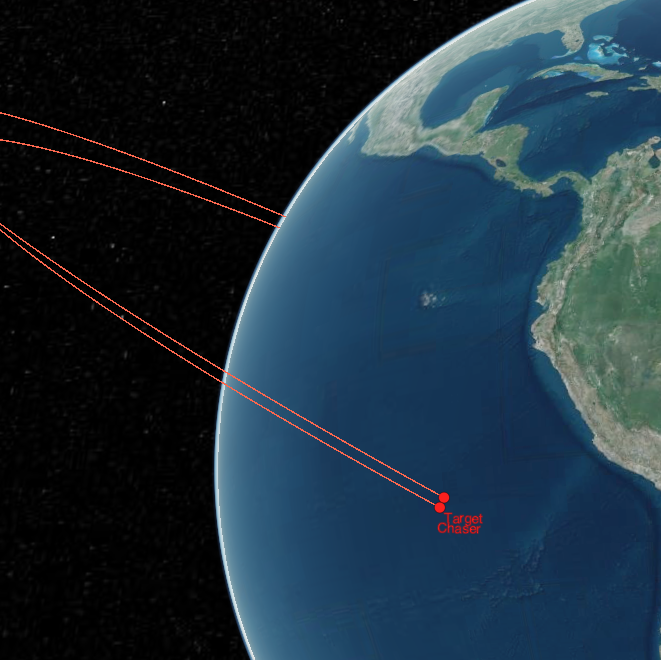

Calculate how close we got, Use the target_sat block ID PM9CbKdVhBjTwj7bMb3TPz  from the Agent block summary list

In [44]:
results.agent('Chaser').block('PM9CbKdVhBjTwj7bMb3TPz').summarize()

---------------------------------------------------------------------------
                   Sedaro Simulation Block Result Summary                  
                                'target_sat'                               
---------------------------------------------------------------------------
🧩 Simulated Modules
    • Guidance, Navigation, & Control

📋 Variables Available
    • agentAzimuth
    • agentElevation
    • beta
    • lineOfSight
    • lst
    • range
    • relativeVelocity
    • shadow
    • targetAzimuth
    • targetElevation
---------------------------------------------------------------------------
❓ Query variables with .<VARIABLE_NAME>


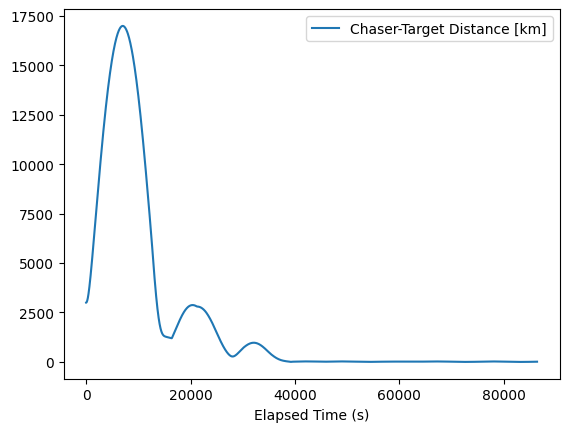

In [64]:
results.agent('Chaser').block('PM9CbKdVhBjTwj7bMb3TPz').range['km'].plot( label="Chaser-Target Distance [km]", show=False)
plt.legend()
plt.show()

In [46]:
min(results.agent('Chaser').block('PM9CbKdVhBjTwj7bMb3TPz').range['km'].values)

1.188012488935362

Zoom in to see the near zero details due to scale

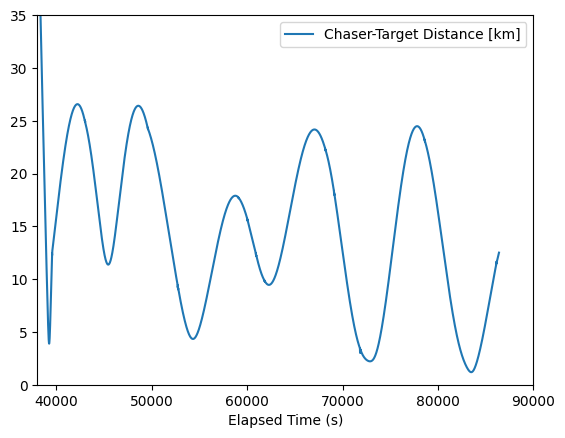

In [62]:
results.agent('Chaser').block('PM9CbKdVhBjTwj7bMb3TPz').range['km'].plot(xlim=[38000,90000], ylim=[0,35], label="Chaser-Target Distance [km]", show=False)
plt.legend()
plt.show()